# Pretrained model - Feature Extraction w/ Data Augmentation
## ONLY USE WITH GPU!!

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
# The path to the directory where the original
# dataset was uncompressed
original_normal_dir = r'.\data\OCT2017\train\NORMAL'
original_cnv_dir = r'.\data\OCT2017\train\CNV'
original_dme_dir = r'.\data\OCT2017\train\DME'
original_drus_dir = r'.\data\OCT2017\train\DRUSEN'

# The directory where we will
# store our smaller dataset
base_dir = r'.\data\OCT2017\stratified_data'
# os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# Directory with our training NORMAL pictures
train_norm_dir = os.path.join(train_dir, 'NORMAL')
# os.mkdir(train_norm_dir)

# Directory with our training CNV pictures
train_cnv_dir = os.path.join(train_dir, 'CNV')
# os.mkdir(train_cnv_dir)

# Directory with our training DME pictures
train_dme_dir = os.path.join(train_dir, 'DME')
# os.mkdir(train_dme_dir)

# Directory with our training DRUSEN pictures
train_drus_dir = os.path.join(train_dir, 'DRUSEN')
# os.mkdir(train_drus_dir)

# Directory with our validation NORMAL pictures
validation_norm_dir = os.path.join(validation_dir, 'NORMAL')
# os.mkdir(validation_norm_dir)

# Directory with our validation CNV pictures
validation_cnv_dir = os.path.join(validation_dir, 'CNV')
# os.mkdir(validation_cnv_dir)

# Directory with our validation DME pictures
validation_dme_dir = os.path.join(validation_dir, 'DME')
# os.mkdir(validation_dme_dir)

# Directory with our validation DRUSEN pictures
validation_drus_dir = os.path.join(validation_dir, 'DRUSEN')
# os.mkdir(validation_drus_dir)

# Directory with our test NORMAL pictures
test_norm_dir = os.path.join(test_dir, 'NORMAL')
# os.mkdir(test_norm_dir)

# Directory with our test CNV pictures
test_cnv_dir = os.path.join(test_dir, 'CNV')
# os.mkdir(test_cnv_dir)

# Directory with our test DME pictures
test_dme_dir = os.path.join(test_dir, 'DME')
# os.mkdir(test_dme_dir)

# Directory with our test DRUSEN pictures
test_drus_dir = os.path.join(test_dir, 'DRUSEN')
# os.mkdir(test_drus_dir)

In [4]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Adding densley connected classifier on to of convolution base

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(4, activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 16,813,124
Trainable params: 16,813,124
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [9]:
conv_base.trainable = False

In [10]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

## Batch_size = 32

In [11]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [14]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 37s 292ms/step - loss: 0.9172 - acc: 0.6626 - val_loss: 0.6852 - val_acc: 0.7450
Epoch 2/50
128/128 [==============================] - 35s 270ms/step - loss: 0.6524 - acc: 0.7634 - val_loss: 0.4380 - val_acc: 0.7962
Epoch 3/50
128/128 [==============================] - 35s 272ms/step - loss: 0.5789 - acc: 0.7810 - val_loss: 0.8002 - val_acc: 0.8106
Epoch 4/50
128/128 [==============================] - 35s 273ms/step - loss: 0.4964 - acc: 0.8193 - val_loss: 0.2778 - val_acc: 0.8431
Epoch 5/50
128/128 [==============================] - 35s 270ms/step - loss: 0.4695 - acc: 0.8247 - val_loss: 0.9306 - val_acc: 0.8444
Epoch 6/50
128/128 [==============================] - 34s 267ms/step - loss: 0.4519 - acc: 0.8401 - val_loss: 0.4248 - val_acc: 0.8656
Epoch 7/50
128/128 [==============================] - 34s 265ms/step - loss: 0.4387 - acc: 0.8381 - val_loss: 0.5404 - val_acc: 0.8687
Epoch 8/50
128/128 [==============================] - 3

In [15]:
model.save('VGG16_tanh32.h5')

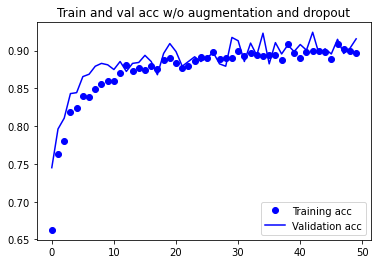

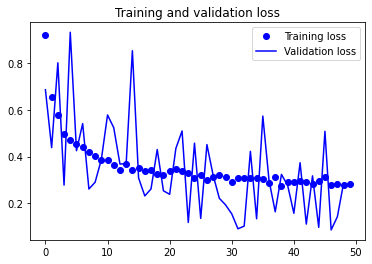

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

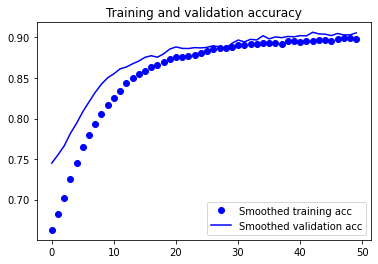

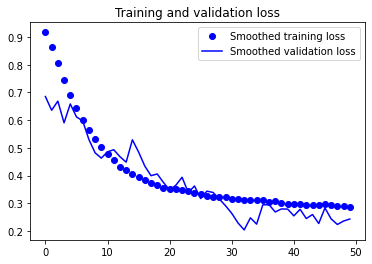

In [19]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.9024999737739563
Wall time: 12.7 s


** ** 
## Batch_size = 64

In [37]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [38]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [40]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 52s 404ms/step - loss: 0.2734 - acc: 0.9050 - val_loss: 0.1811 - val_acc: 0.9131
Epoch 2/50
128/128 [==============================] - 49s 381ms/step - loss: 0.2690 - acc: 0.9044 - val_loss: 0.2622 - val_acc: 0.9209
Epoch 3/50
128/128 [==============================] - 48s 373ms/step - loss: 0.2624 - acc: 0.9067 - val_loss: 0.3564 - val_acc: 0.9047
Epoch 4/50
128/128 [==============================] - 47s 366ms/step - loss: 0.2921 - acc: 0.9006 - val_loss: 0.1029 - val_acc: 0.9047
Epoch 5/50
128/128 [==============================] - 46s 357ms/step - loss: 0.2735 - acc: 0.9069 - val_loss: 0.1580 - val_acc: 0.9147
Epoch 6/50
128/128 [==============================] - 45s 355ms/step - loss: 0.2796 - acc: 0.9006 - val_loss: 0.3753 - val_acc: 0.9038
Epoch 7/50
128/128 [==============================] - 46s 360ms/step - loss: 0.2596 - acc: 0.9083 - val_loss: 0.3589 - val_acc: 0.9175
Epoch 8/50
128/128 [==============================] - 4

In [41]:
model.save('VGG16_tanh64.h5')

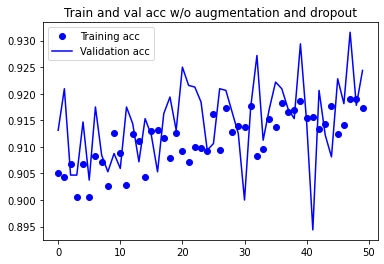

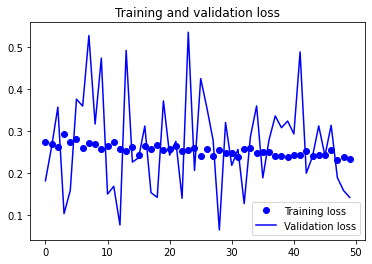

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

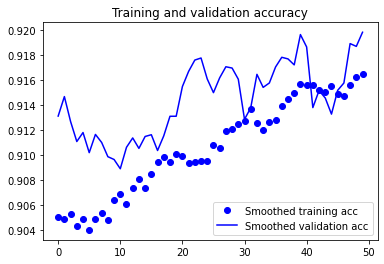

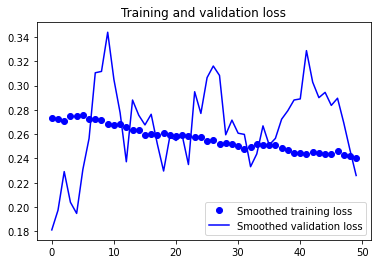

In [43]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.921999990940094
Wall time: 10.6 s


** ** 
## Batch_size = 128

In [45]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='categorical')

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [46]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [48]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 97s 754ms/step - loss: 0.2344 - acc: 0.9180 - val_loss: 0.3289 - val_acc: 0.9247
Epoch 2/50
128/128 [==============================] - 91s 713ms/step - loss: 0.2353 - acc: 0.9168 - val_loss: 0.1746 - val_acc: 0.9247
Epoch 3/50
128/128 [==============================] - 91s 713ms/step - loss: 0.2371 - acc: 0.9175 - val_loss: 0.2568 - val_acc: 0.9236
Epoch 4/50
128/128 [==============================] - 94s 731ms/step - loss: 0.2255 - acc: 0.9226 - val_loss: 0.2623 - val_acc: 0.8833
Epoch 5/50
128/128 [==============================] - 93s 723ms/step - loss: 0.2349 - acc: 0.9169 - val_loss: 0.1622 - val_acc: 0.9209
Epoch 6/50
128/128 [==============================] - 93s 724ms/step - loss: 0.2346 - acc: 0.9200 - val_loss: 0.2487 - val_acc: 0.9252
Epoch 7/50
128/128 [==============================] - 94s 735ms/step - loss: 0.2202 - acc: 0.9239 - val_loss: 0.2301 - val_acc: 0.9134
Epoch 8/50
128/128 [==============================] - 9

In [49]:
model.save('VGG16_tanh128.h5')

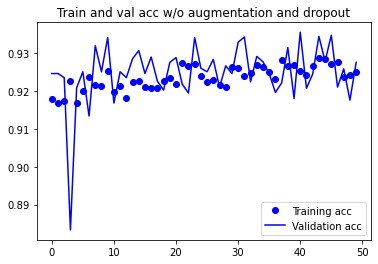

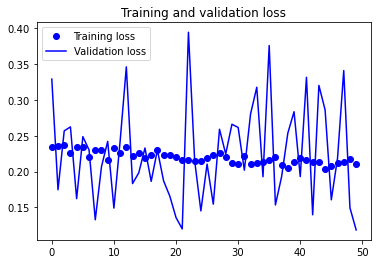

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

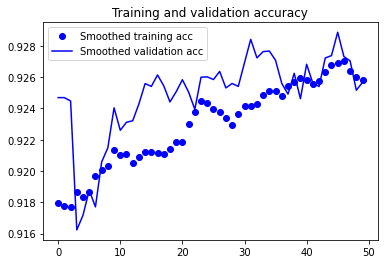

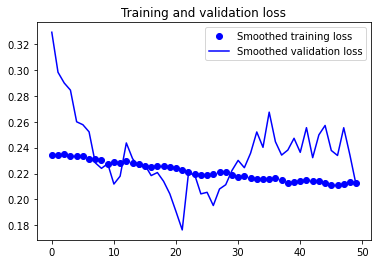

In [51]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.9240000247955322
Wall time: 10 s


** ** 
## Batch_size = 256

In [53]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

Found 62208 images belonging to 4 classes.
Found 3968 images belonging to 4 classes.


In [54]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [56]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=128,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/50
128/128 [==============================] - 199s 2s/step - loss: 0.2015 - acc: 0.9292 - val_loss: 0.1996 - val_acc: 0.9286
Epoch 2/50
128/128 [==============================] - 185s 1s/step - loss: 0.2068 - acc: 0.9292 - val_loss: 0.3251 - val_acc: 0.9282
Epoch 3/50
128/128 [==============================] - 184s 1s/step - loss: 0.2032 - acc: 0.9279 - val_loss: 0.2105 - val_acc: 0.9343
Epoch 4/50
128/128 [==============================] - 185s 1s/step - loss: 0.2025 - acc: 0.9306 - val_loss: 0.1449 - val_acc: 0.9368
Epoch 5/50
128/128 [==============================] - 186s 1s/step - loss: 0.2022 - acc: 0.9287 - val_loss: 0.1605 - val_acc: 0.9282
Epoch 6/50
128/128 [==============================] - 186s 1s/step - loss: 0.1999 - acc: 0.9317 - val_loss: 0.2429 - val_acc: 0.9224
Epoch 7/50
128/128 [==============================] - 186s 1s/step - loss: 0.1981 - acc: 0.9313 - val_loss: 0.2086 - val_acc: 0.9300
Epoch 8/50
128/128 [==============================] - 185s 1s/step - 

In [57]:
model.save('VGG16_tanh256.h5')

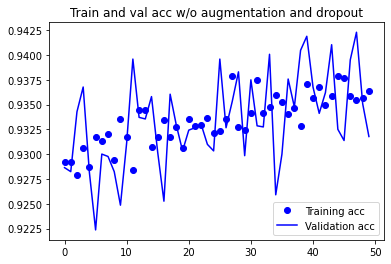

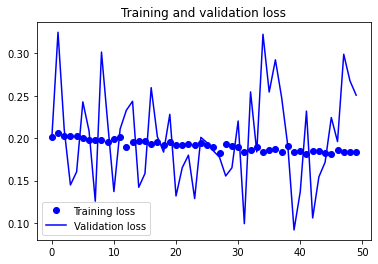

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and val acc w/o augmentation and dropout')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

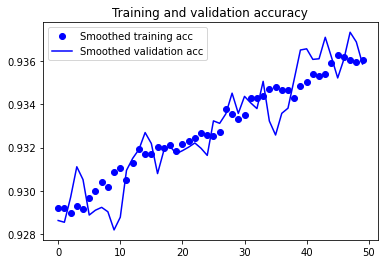

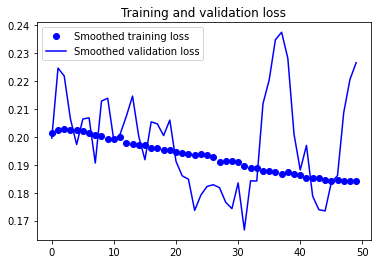

In [59]:
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 17308 images belonging to 4 classes.
test acc: 0.9294999837875366
Wall time: 9.79 s


## Comparison

In [2]:
train_time = {"relu":{"batch_256":149,
                      "batch_128":76,
                      "batch_64":38,
                      "batch_32":25
                     },
              "tanh":{"batch_256":156,
                      "batch_128":78,
                      "batch_64":38,
                      "batch_32":23
                     }
             }

accuracies = {"relu":{"batch_256":0.948,
                      "batch_128":0.895,
                      "batch_64":0.905,
                      "batch_32":0.896
                     },
              "tanh":{"batch_256":0.929,
                      "batch_128":0.924,
                      "batch_64":0.922,
                      "batch_32":0.902
                     }
             }

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
## dict to df
df_traintime = pd.DataFrame.from_dict(train_time)
df_accuracies = pd.DataFrame.from_dict(accuracies)

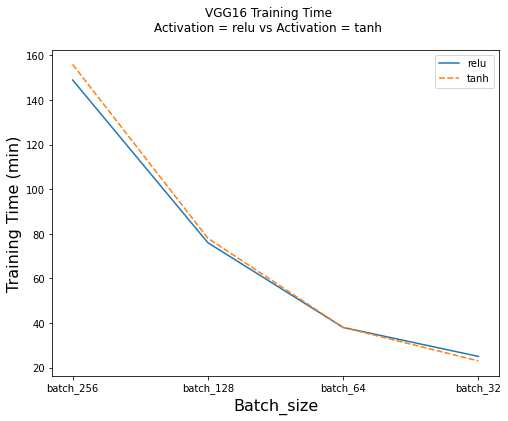

In [38]:
plt.subplots(figsize = (8,6))
plt.suptitle("VGG16 Training Time\nActivation = relu vs Activation = tanh")
plt.xlabel("Batch_size", fontsize=16)
plt.ylabel("Training Time (min)", fontsize=16)

sns.lineplot(data=df_traintime)

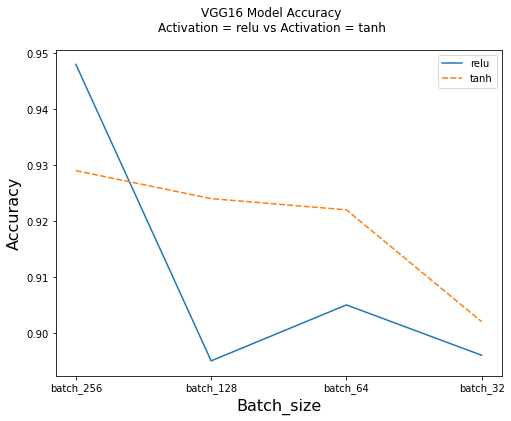

In [39]:
plt.subplots(figsize = (8,6))
plt.suptitle("VGG16 Model Accuracy\nActivation = relu vs Activation = tanh")
plt.xlabel("Batch_size", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

sns.lineplot(data=df_accuracies)